Import all the needed libraries

In [1]:
!pip install tensorflow kaggle keras scikit-learn visualkeras keras.utils

In [103]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image as mpimg
import matplotlib as mpl
import seaborn as sns
from scipy.io import loadmat
import scipy.io as sio
from skimage import color
from skimage import io
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
import os
import time
import gzip
import itertools
from __future__ import absolute_import
from __future__ import print_function
from datetime import timedelta
import h5py
import keras
import visualkeras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
import sklearn
from sklearn import neighbors, metrics
from PIL import ImageFont
from keras.models import Sequential
from keras.layers import Input
from keras.layers import Reshape
from keras.models import Model
from keras.layers import Conv1D, Conv2D, Conv3D, SeparableConv1D, MaxPooling1D, Activation, MaxPooling2D, Dense, Flatten, GlobalAveragePooling2D, BatchNormalization, Conv2D, Dropout
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras import layers
from keras.applications import VGG19
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.initializers import RandomNormal

np.random.seed(20)
%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 4.0)

In [3]:
TENSORBOARD_SUMMARIES_DIR = '/tmp/svhn_classifier_logs'

The following code is used to convert the images from rgb to greyscale

In [4]:
def rgb2gray(images):
    return np.expand_dims(np.dot(images, [0.2990, 0.5870, 0.1140]), axis=3)

In [65]:
def lr_scheduler(epoch, lr):
    if epoch % 10 == 0 and epoch != 0:
        lr = lr / 2
    return lr

The following code gets used to plot the images as a terminal output

In [5]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix', cmap=plt.cm.tab20b):
    """
    This function prints and plots the confusion matrix. 
    Normalization can be applied by setting normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm. sum (axis=1)[:, np.newaxis] 
        print("Normalized confusion matrix")
    else:    
        print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product (range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j]> thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [6]:
def plot_images(img, labels, nrows, ncols):
    """ Plot nrows x ncols images
    """
    fig, axes = plt.subplots(nrows, ncols)
    for i, ax in enumerate(axes.flat): 
        if img[i].shape == (32, 32, 3):
            ax.imshow(img[i])
        else:
            ax.imshow(img[i,:,:,0])
        ax.set_xticks([]); ax.set_yticks([])
        ax.set_title(labels[i])

In [7]:
def get_batch(X, y, batch_size=512):
    for i in np.arange(0, y.shape[0], batch_size):
        end = min(X.shape[0], i + batch_size)
        yield(X[i:end],y[i:end])

In [8]:
def prepare_log_dir():
    '''Clears the log files then creates new directories to place
        the tensorbard log file.''' 
    if tf.gfile.Exists(TENSORBOARD_SUMMARIES_DIR):
        tf.gfile.DeleteRecursively(TENSORBOARD_SUMMARIES_DIR)
    tf.gfile.MakeDirs(TENSORBOARD_SUMMARIES_DIR)

The following code loads the data from the .mat file into numpy arrays

In [98]:
def create_keras_model():
    
    keras.backend.clear_session()

    initializer = RandomNormal(mean=0.0, stddev=0.01)

    initializer2 = RandomNormal(mean=0.0, stddev=0.01)
    
    model = Sequential()
    
    model.add(keras.applications.resnet.ResNet50(include_top=False,input_shape=(32,32,3), pooling='avg', weights='imagenet'))

    model.add(Flatten())
    
    model.add(BatchNormalization())
    
    model.add(Dense(2048, activation='relu', kernel_initializer=initializer))
    
    model.add(Dropout(0.3))

    model.add(BatchNormalization())
    
    model.add(Dense(1024, activation='relu', kernel_initializer=initializer2))
    
    model.add(Dropout(0.4))
    
    model.add(Dense(10, activation='softmax'))

    model.layers[0].trainable = False
    
    optimizer = keras.optimizers.Adam(amsgrad=True, clipnorm=1.0, learning_rate=1e-2)
    
    model.compile(optimizer=optimizer,
    loss='categorical_focal_crossentropy',
    metrics=['accuracy'])
    
    return model

In [10]:
def load_data(path):
    """ Helper function for loading a MAT-File"""
    data = loadmat(path)
    return data['X'], data['y']

In [11]:
X_train, y_train = load_data('train_32x32.mat')
X_test, y_test = load_data('test_32x32.mat')

print("Training Set", X_train.shape, y_train.shape)
print("Test Set", X_test.shape, y_test.shape)

Training Set (32, 32, 3, 73257) (73257, 1)
Test Set (32, 32, 3, 26032) (26032, 1)


The following code gets used to transpose the arrays and calculate the total number of images

In [12]:
X_train, y_train = X_train.transpose((3,0,1,2)), y_train[:,0]
X_test, y_test = X_test.transpose((3,0,1,2)), y_test[:,0]

print("Training Set", X_train.shape)
print("Test Set", X_test.shape)
print("Training Label Set", y_train.shape)
print("Test Label Set", y_test.shape)
print('')

num_images = X_train.shape[0] + X_test.shape[0]

print("Total Number of Images", num_images)

Training Set (73257, 32, 32, 3)
Test Set (26032, 32, 32, 3)
Training Label Set (73257,)
Test Label Set (26032,)

Total Number of Images 99289


Plotting some training images

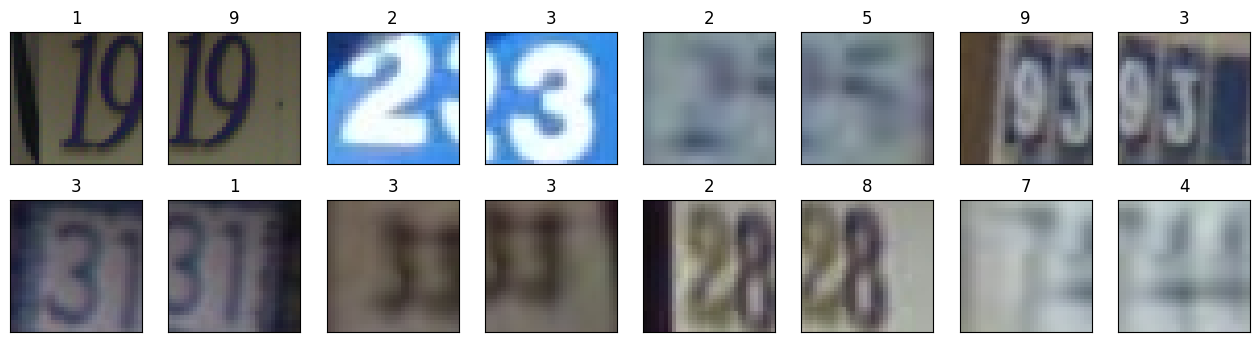

In [13]:
plot_images(X_train, y_train, 2, 8)

Plotting some test images

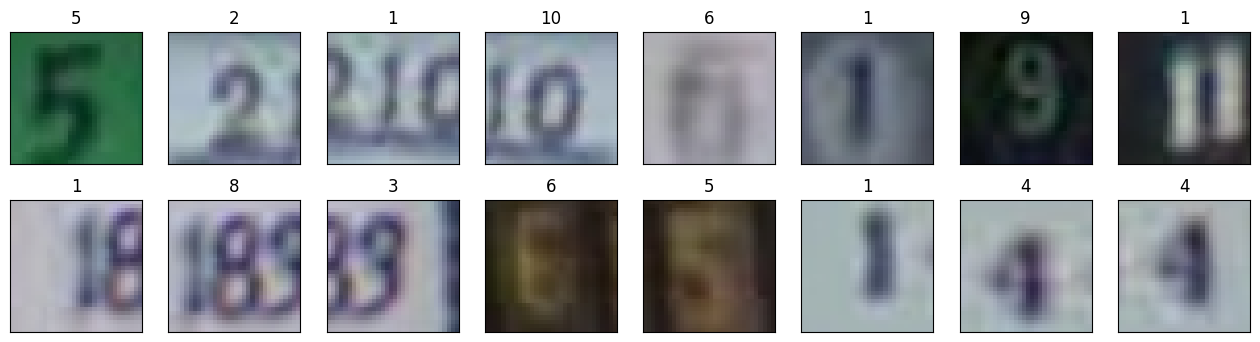

In [14]:
plot_images(X_test, y_test, 2, 8)

Rename the 10th value to 0

In [15]:
y_train[y_train == 10] = 0
y_test[y_test == 10] = 0
print(np.unique(y_train))
print(np.unique(y_test))

[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]


Verify the shat of the label arrays

In [16]:
y_train.shape, y_test.shape

((73257,), (26032,))

Generate a class distribution of the images by their labels

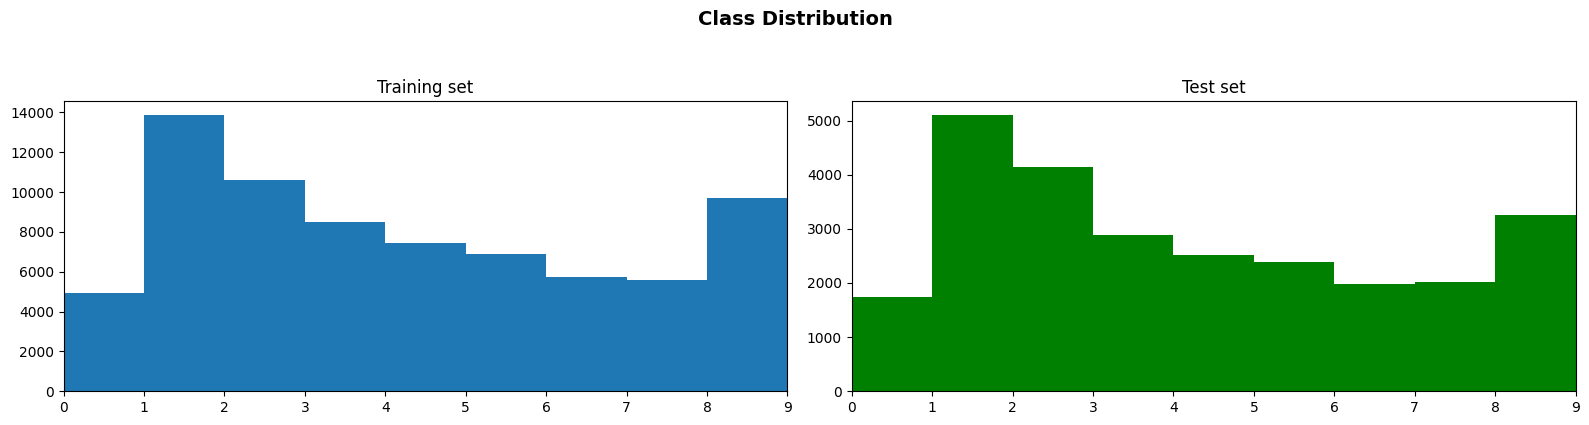

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True)

fig.suptitle('Class Distribution', fontsize=14, fontweight='bold', y=1.05)

ax1.hist(y_train, bins=9)
ax1.set_title("Training set")
ax1.set_xlim(0,9)

ax2.hist(y_test, color='g', bins=9)
ax2.set_title("Test set")

fig.tight_layout()

Normalising the data

One hot encoding the labels to convert them from categorical to numerical

In [18]:
enc = OneHotEncoder().fit(y_train.reshape(-1, 1))

y_train = enc.transform(y_train.reshape(-1, 1)).toarray()
y_test = enc.transform(y_test.reshape(-1, 1)).toarray()

print("Training set", y_train.shape)
print("Test set", y_test.shape)

Training set (73257, 10)
Test set (26032, 10)


Storing the grascale data to a file for use in training

In [19]:
h5f = h5py.File('SVHN_rgb.h5', 'w')
h5f.create_dataset('X_train', data=X_train)
h5f.create_dataset('y_train', data=y_train)
h5f.create_dataset('X_test', data=X_test)
h5f.create_dataset('y_test', data=y_test)
h5f.close()

In [91]:
h5f = h5py.File('SVHN_rgb.h5', 'r')

# Load the training, test and validation set
X_train = h5f['X_train'][:]
y_train = h5f['y_train'][:]
X_test = h5f['X_test'][:]
y_test = h5f['y_test'][:]

# Close this file
h5f.close()

print('Training set', X_train.shape, y_train.shape)
print('Test set', X_test.shape, y_test.shape)

Training set (73257, 32, 32, 3) (73257, 10)
Test set (26032, 32, 32, 3) (26032, 10)


In [92]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size=0.3, random_state=23)

In [93]:
datagen = ImageDataGenerator(rotation_range=8,
                             zoom_range=[0.95, 1.05],
                             height_shift_range=0.15,
                             shear_range=0.2)

In [99]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

model_checkpoint = keras.callbacks.ModelCheckpoint(
'best_cnn',
save_best_only=True)

lr_schedule = LearningRateScheduler(lr_scheduler)

model = create_keras_model()

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 2048)              4196352   
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 batch_normalization_1 (Bat  (None, 2048)              8192      
 chNormalization)                                       

In [100]:
visualkeras.layered_view(model, to_file='output.png').show()

/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: elinks: not found
/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no method available for opening '/tmp/tmpxywcbqtu.PNG'


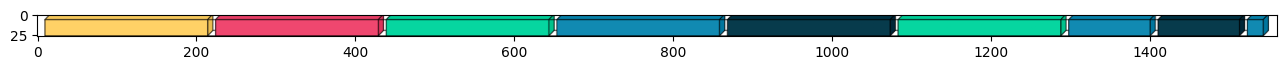

In [101]:
image = mpimg.imread("output.png")
plt.imshow(image)
plt.show()

In [102]:
start = time.time()
history = model.fit(datagen.flow(X_train, y_train, batch_size=128),
                              epochs=70, validation_data=(X_val, y_val),
                              callbacks=[early_stopping,lr_schedule])
end = time.time()
print("CNN ResNet Fit Time: ", end - start,"s")

Epoch 1/70
401/401 [==============================] - 116s 272ms/step - loss: 0.3231 - accuracy: 0.3890 - val_loss: 0.2662 - val_accuracy: 0.4653 - lr: 1.0000e-04
Epoch 2/70
401/401 [==============================] - 110s 275ms/step - loss: 0.2799 - accuracy: 0.4508 - val_loss: 0.2550 - val_accuracy: 0.4832 - lr: 1.0000e-04
Epoch 3/70
401/401 [==============================] - 112s 279ms/step - loss: 0.2664 - accuracy: 0.4671 - val_loss: 0.2489 - val_accuracy: 0.4956 - lr: 1.0000e-04
Epoch 4/70
401/401 [==============================] - 116s 289ms/step - loss: 0.2545 - accuracy: 0.4845 - val_loss: 0.2461 - val_accuracy: 0.5030 - lr: 1.0000e-04
Epoch 5/70
401/401 [==============================] - 114s 285ms/step - loss: 0.2464 - accuracy: 0.4983 - val_loss: 0.2411 - val_accuracy: 0.5091 - lr: 1.0000e-04
Epoch 6/70
401/401 [==============================] - 114s 283ms/step - loss: 0.2387 - accuracy: 0.5094 - val_loss: 0.2383 - val_accuracy: 0.5173 - lr: 1.0000e-04
Epoch 7/70
401/401 [==

KeyboardInterrupt: 

In [ ]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Epochs vs. Training and Validation Accuracy')
    
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Epochs vs. Training and Validation Loss')

plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(x=X_test, y=y_test, verbose=0)
print('Test accuracy is: {:0.4f} \nTest loss is: {:0.4f}'.
      format(test_acc, test_loss))

In [ ]:
start = time.time()
x_test = X_test
y_true = y_test
y_pred = model.predict(x_test)
y_true_classes = np.argmax(y_true, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)
end = time.time()
print("CNN Predict Time: ", end - start,"s")

In [ ]:
cm = metrics.confusion_matrix(y_true_classes, y_pred_classes)
plot_confusion_matrix(cm, ["0","1","2","3","4","5","6","7","8","9"]) 

In [ ]:
plt.figure(figsize=(12, 8))
cm = confusion_matrix(y_true=np.argmax(y_test, axis=1), y_pred=y_pred_classes)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100.00
sns.heatmap(cm, annot=True, cmap='Reds', fmt='.1f', square=True);